Installation des packages

In [1]:
# 2 min
#!pip install -q -q -q tifffile
#!pip install -q -q -q tqdm # progresbar
#!pip3 install -q -q -q torch==1.9.0+cu102 torchvision==0.10.0+cu102 torchaudio===0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
# https://pytorch.org/get-started/locally/#mac-anaconda
# Bien surveiller les versions de torch et prendre la nigthly si besoin ! là j'ai pris la dernière :)
#!pip3 install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu116 -q -q -q
!pip install py7zr  -q -q -q 
!pip3 install opencv-python -q -q -q 
!pip install matplotlib
! pip install geopandas
! pip install geocube
#!pip install imageio  -q -q -q 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 17.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.1/296.1 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 12.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 11.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 9.1 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 11.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 14.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

On installe les dépendances nécessaires à Open cv cf https://stackoverflow.com/questions/55313610/importerror-libgl-so-1-cannot-open-shared-object-file-no-such-file-or-directo :
Dans le terminal !

sudo apt-get update
sudo apt-get install ffmpeg libsm6 libxext6  -y 

In [2]:
import s3fs
from pathlib import Path
import py7zr
import numpy as np
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import geopandas as gpd

Récupération des données pleiades

In [3]:
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': 'https://minio.lab.sspcloud.fr'})
fs.get('projet-slums-detection/Donnees/Cayenne_200722.7z', 'Cayenne.7z')
with py7zr.SevenZipFile('Cayenne.7z', mode='r') as z:
    z.extractall()

- ce sont des images de 2000x2000 pixels à 50 cm le pixel =>1000x1000 m^2 = 1km^2
- On en a 240 Dans le fichier brut or la superficie de Cayenne est égale à 23,6 km^2
- 4 channels RGB Infra
- Le fichier pour Cayenne fait 2 Gigas.. ça va vite..

Normalisation OpenCv

## Comment installer gdal...
GDAL vaut pour Geospatial analysis library et permet demodifier simplement des ensembles d'images raster contenus dans un même sous dossier

https://mothergeo-py.readthedocs.io/en/latest/development/how-to/gdal-ubuntu-pkg.html
Dans le terminal ! :

- sudo add-apt-repository ppa:ubuntugis/ppa && sudo apt-get update
- sudo apt-get update
- sudo apt-get install gdal-bin
- sudo apt-get install libgdal-dev
- export CPLUS_INCLUDE_PATH=/usr/include/gdal
- export C_INCLUDE_PATH=/usr/include/gdal
- pip install GDAL==3.0.4

Puis on obtent l'erreur 2to3 invalid corrigeable via ce lien :
https://bobbyhadz.com/blog/python-error-in-package-setup-command-use-2to3-is-invalid
- pip install "setuptools<58.0"
- pip3 install "setuptools<58.0"
- python -m pip install "setuptools<58.0"
- python3 -m pip install "setuptools<58.0"
- py -m pip install "setuptools<58.0"


Et enfin !!!

-pip install GDAL==3.0.4

Enfin le graal tant attendu :

In [ ]:
from osgeo import ogr
from osgeo import gdal

Maintenant On va créer un raster virtuel à partir d'un dossier d'image en python, c'est l'analogue de la commande de Philippe :

/*création d'un raster virtuel affichable dans Qgis à partir des fichiers jp2 obtenus : image en 16 bits avec 4 bandes et pixel 50 cm*/
gdalbuildvrt Cayenne_2022.vrt ./16bits/ORT_2022072050325085_U22N/*.jp2


In [ ]:
im_dir = "Cayenne_200722/16bits/ORT_2022072050325085_U22N/"
liste  = os.listdir(im_dir)
list_path_image = [im_dir+l for l in liste]

In [ ]:
vrt_options = gdal.BuildVRTOptions(resampleAlg='cubic', addAlpha=True)
my_vrt = gdal.BuildVRT('Cayenne.vrt',list_path_image, options=vrt_options)
my_vrt = None
A suivre..

## Rasterio 
Ok un package est déjà copnstruit par dessus gdal pour gérer les raster, rasterio package 
https://geohackweek.github.io/raster/04-workingwithrasters/

In [4]:
!pip install rasterio # marche indépendemment des instalaltions précédentes !!

In [98]:
import rasterio
import rasterio.plot as rp
from rasterio.merge import merge
from rasterio.warp import calculate_default_transform, reproject, Resampling
#import pyproj
from rasterio.plot import show
from rasterio.crs import CRS
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
from rasterio.features import rasterize

In [6]:
im_dir = "Cayenne_200722/16bits/ORT_2022072050325085_U22N/"
liste  = os.listdir(im_dir)
list_path_image = [im_dir+l for l in liste]

len(liste)


240

In [82]:
list_path_image[200] 

'Cayenne_200722/16bits/ORT_2022072050325085_U22N/ORT_2022072050325085_0354_0536_U22N_16Bits.jp2'

In [83]:

## caractéristique d'une image
filepath = list_path_image[200] 
filepath = 'Cayenne_200722/16bits/ORT_2022072050325085_U22N/ORT_2022072050325085_0353_0545_U22N_16Bits.jp2'
# 72 et 37 bons exemples
with rasterio.open(filepath) as raster:
    print(raster.profile)
# en se servant du nom on peut faire des mosaiques  en filtrant sur les chiffres

{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 2000, 'height': 2000, 'count': 4, 'crs': CRS.from_epsg(2972), 'transform': Affine(0.5, 0.0, 353000.0,
       0.0, -0.5, 545000.0), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True, 'interleave': 'pixel'}


[2, 4, 8, 16]


Text(0, 0.5, 'Pixels Lignes')

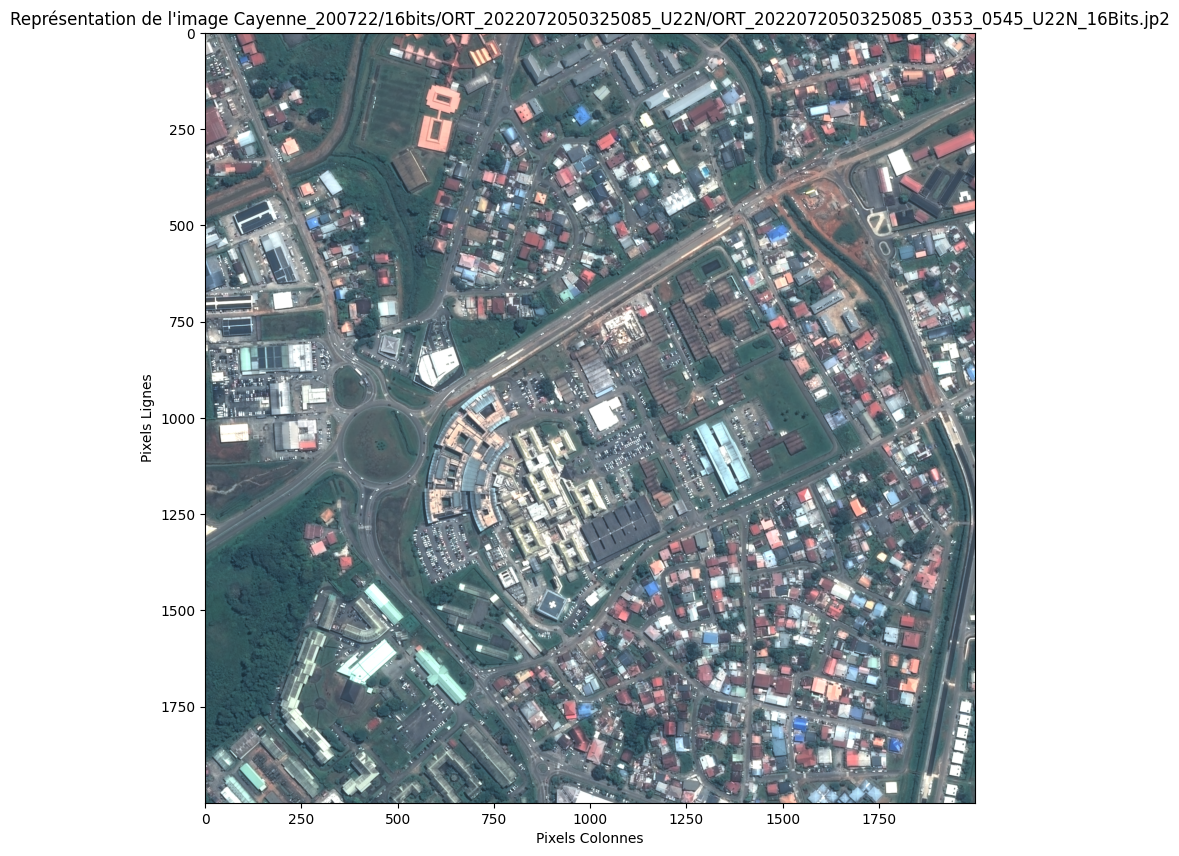

In [84]:
# The grid of raster values can be accessed as a numpy array and plotted:
with rasterio.open(filepath) as raster:
    oviews = raster.overviews(1) # list of overviews from biggest to smallest
    print(oviews)
    oview = 1 # let's look at the smallest thumbnail

    # NOTE this is using a 'decimated read' (http://rasterio.readthedocs.io/en/latest/topics/resampling.html)
    B1 = raster.read(1, out_shape=(1, int(raster.height // oview), int(raster.width // oview)))
    B2 = raster.read(2, out_shape=(1, int(raster.height // oview), int(raster.width // oview)))
    B3 = raster.read(3, out_shape=(1, int(raster.height // oview), int(raster.width // oview)))
    B4 = raster.read(4, out_shape=(1, int(raster.height // oview), int(raster.width // oview)))
        
B1a = rp.adjust_band(np.clip(B1,0,np.quantile(B1,0.97))) # normalisation min-max simple nécessite un clip d'abord étant donné les valeurs extremes
B2a = rp.adjust_band(np.clip(B2,0,np.quantile(B2,0.97)))
B3a = rp.adjust_band(np.clip(B3,0,np.quantile(B3,0.97)))
B4a = rp.adjust_band(np.clip(B4,0,np.quantile(B4,0.97)))

rgb = np.dstack((B1a,B2a,B3a))
rgbvegetal = np.dstack((B4a,B1a,B2a))

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(rgb)
plt.title("Représentation de l'image {}".format(filepath))
plt.xlabel('Pixels Colonnes')
plt.ylabel('Pixels Lignes')


La bande infrarouge permet de détecter la végétation avec précision

Text(0, 0.5, 'Pixels Lignes')

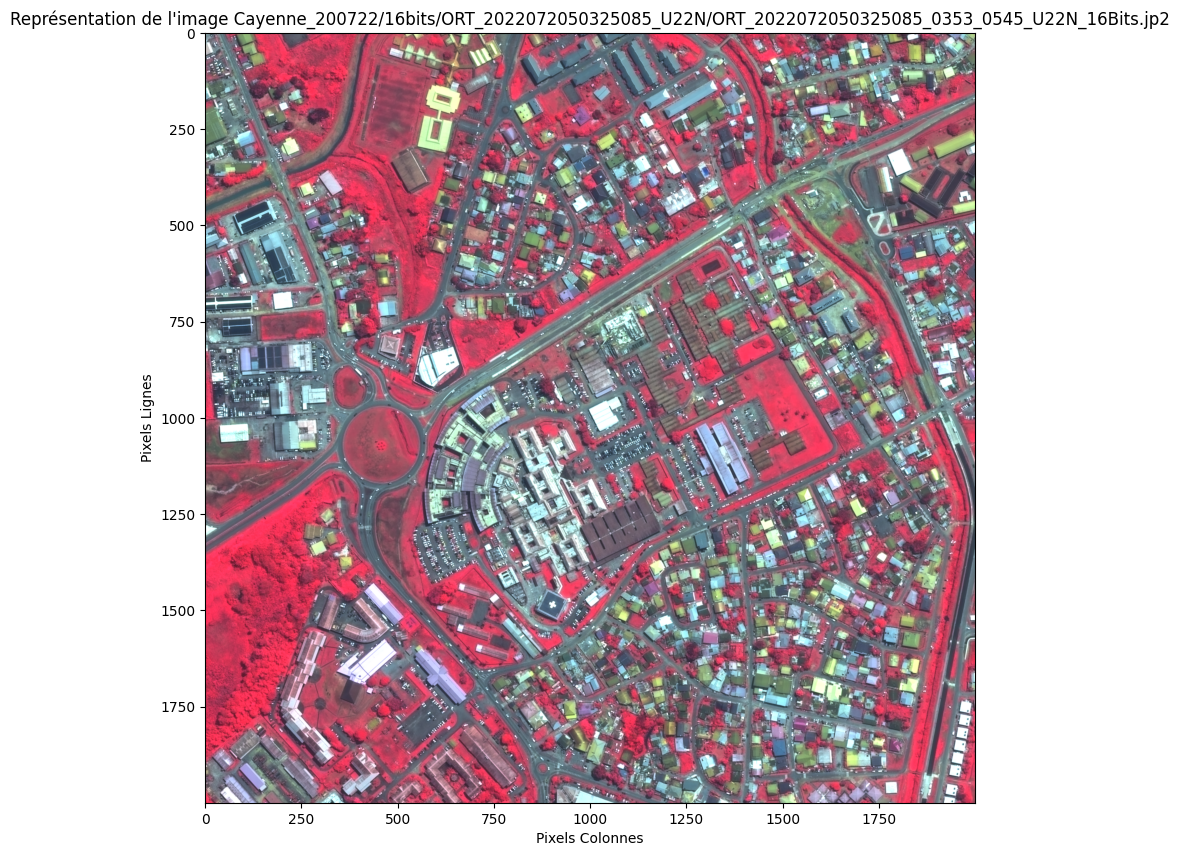

In [85]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(rgbvegetal)
plt.title("Représentation de l'image {}".format(filepath))
plt.xlabel('Pixels Colonnes')
plt.ylabel('Pixels Lignes')


Donne envie de proposer une méthode batarde benchmark basée sur l'infra rouge.. en faisant du N / N-1 On
pourrait comparer les distributions ebntre 2 photos

La bible en manipulation avec rasterio <3
https://automating-gis-processes.github.io/CSC/notebooks/L5/raster-mosaic.html

Petites fonctions de clip + normal, normaliser avant de clipper aplatit tout vers 0

In [86]:
def clipQuant(array,quant):
    out = rp.adjust_band(np.clip(array,0,np.quantile(array,quant)))
    return(out)

def climNormStack(raster):
    oview = 1
    B1 = raster.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))
    B2 = raster.read(2, out_shape=(1, int(src.height // oview), int(src.width // oview)))
    B3 = raster.read(3, out_shape=(1, int(src.height // oview), int(src.width // oview)))
    B4 = raster.read(4, out_shape=(1, int(src.height // oview), int(src.width // oview)))

    B1a = clipQuant(B1,0.97) # normalisation min-max simple nécessite un clip d'abord étant donné les valeurs extremes
    B2a = clipQuant(B2,0.97)
    B3a = clipQuant(B3,0.97)
    B4a = clipQuant(B4,0.97)

    rgb = np.dstack((B1a,B2a,B3a))
    
    return(rgb)

### Passage le raster à la géométrie GPS

On peut transformer les données en GPS
On peut également avoir les limites géographique de l'image
cf ici : https://rasterio.readthedocs.io/en/latest/topics/reproject.html
On a peut-être meilleur temps de transformer les donénes RIL dans le bon EPSG mais pour la forme déjà

In [91]:
dst_crs = 'EPSG:4326'

with rasterio.open(filepath) as src:
    print(src.profile)
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    
    width = height = src.width # je contrains 
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    with rasterio.open('tmp.tif', 'w', **kwargs) as dst: # écriture de la reprojectiond ans un tiff
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs)
            


{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 2000, 'height': 2000, 'count': 4, 'crs': CRS.from_epsg(2972), 'transform': Affine(0.5, 0.0, 353000.0,
       0.0, -0.5, 545000.0), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True, 'interleave': 'pixel'}


In [92]:
rasterwgs84 = rasterio.open('tmp.tif')
rasterwgs84.bounds 
# taper ça sur google maps 4.884134284920419,-52.33475138708756  (bord en bas à gauche) pour vérifier !
# ça marche :)

BoundingBox(left=-52.32580589928141, bottom=4.920328778395846, right=-52.31677510776761, top=4.929359569909651)

## Récupération du RIL

Maintenant on va vouloir se servir de la bounding box du raster.bounds pour récupérer les points RIL à l'intérieur de cette zone et voir ce que ça donne
On récupère également le Ril de Cayenne prétransformer au format geopackage (il ne reste plus que les coordonnées dedanss) et déjà projeter en corordonnées GPS


In [42]:
#import s3fs
#fs = s3fs.S3FileSystem(#se connecter en allant dans connexion to storage etc.. dans onyxia)
fs.get('projet-slums-detection/Donnees/ril_cayenne.gpkg', 'ril_cayenne.gpkg')

Pour superposer points et rasters
https://stackoverflow.com/questions/57535504/how-to-plot-spatial-points-over-a-raster-layer-python

In [90]:
ril_cayenne  = gpd.read_file("ril_cayenne.gpkg")

# on borne le gpd sur le patch
xmin, ymin, xmax, ymax = rasterwgs84.bounds
ril_patch = ril_cayenne.cx[xmin:xmax,ymin:ymax]


           id  code_epsg                   geometry
0      517691       2972  POINT (-52.30598 4.94728)
1      517692       2972  POINT (-52.30735 4.94634)
2      517693       2972  POINT (-52.30616 4.94576)
3      517694       2972  POINT (-52.31104 4.94571)
4      517695       2972  POINT (-52.31052 4.94546)
...       ...        ...                        ...
24763  542454       2972  POINT (-52.31887 4.92325)
24764  542455       2972  POINT (-52.31009 4.91674)
24765  542456       2972  POINT (-52.30084 4.93910)
24766  542457       2972  POINT (-52.33018 4.94086)
24767  542458       2972  POINT (-52.30510 4.94633)

[24768 rows x 3 columns]
BoundingBox(left=-52.32580589928141, bottom=4.920328778395846, right=-52.31677510776761, top=4.929359569909651)
-52.32580589928141 4.920328778395846 -52.31677510776761 4.929359569909651


1483

### Plus qu'à superposer !

<AxesSubplot: >

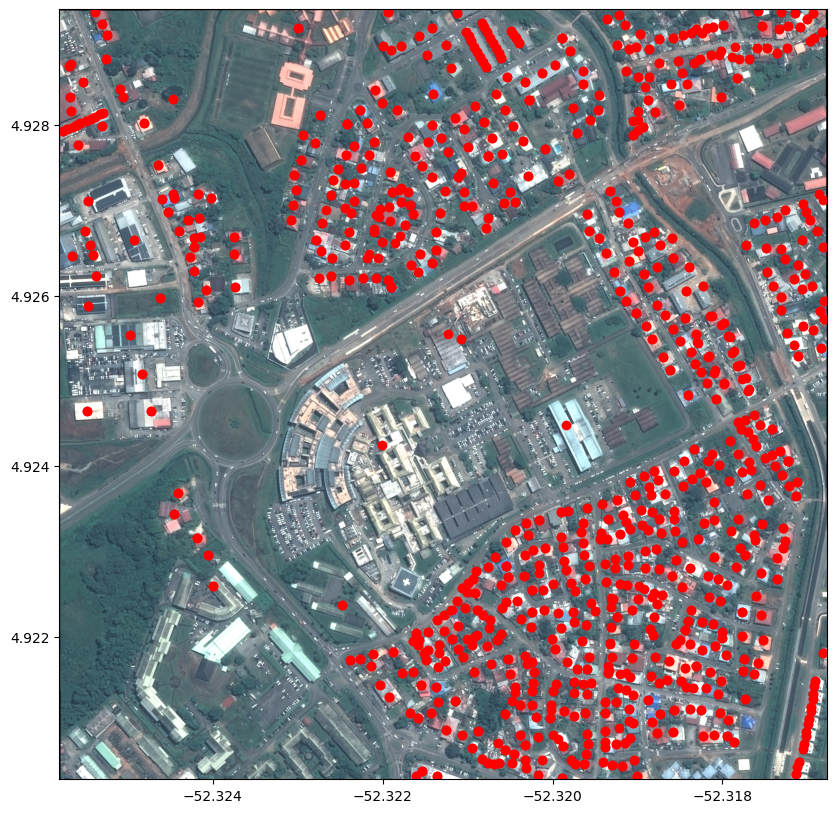

In [93]:
raster_extent = [rasterwgs84.bounds[0], rasterwgs84.bounds[2], rasterwgs84.bounds[1], rasterwgs84.bounds[3]]

red = rasterwgs84.read(1)
fig, ax = plt.subplots(figsize=(10, 10))
show(
    np.moveaxis(climNormStack(rasterwgs84), -1, 0),
    extent = raster_extent,  # sans ce paramètre c'est infaisable.. cf https://stackoverflow.com/questions/61980063/python-how-to-place-a-shapefile-on-top-of-raster-file-in-one-plot-and-then-sa
    ax=ax
)
ril_patch.plot(color = "red",ax = ax)


## Rasteriszation des points

Ici je veux rasterizer les points pour produire le fameux masqure d'entrainement de même dimension que l'image
LE processus est facilement réalisable avec la foinctiion rasterize
https://pygis.io/docs/e_raster_rasterize.html

Au passage la bible sur geopandas :
https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.cx.html

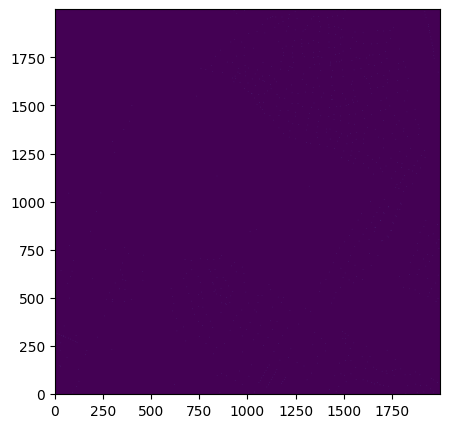

In [105]:
rasterized = rasterize(ril_patch.geometry,
                                out_shape = rasterwgs84.shape,
                                fill = 0,
                                out = None,
                                transform = rasterwgs84.transform,
                                all_touched = True,
                                default_value = 1,
                                dtype = None)

# Plot raster
fig, ax = plt.subplots(1, figsize = (5, 5))
show(rasterized, ax = ax)
plt.gca().invert_yaxis()


Evidemment on ne voit rien car on a- un. petit ensemble de points sur un carré de 2000 x 2000..

In [109]:
rasterized.shape
print(sum(rasterized[rasterized !=0]))
print(len(ril_patch))

774
1483


774 pixels passés à 1 dans le raster versus les 1483 points présents dans le patch, difficile de comprendre pour quoi
Il est certainement plus judicieux de faire des buffer autour des  points puis de rasterizer. (le gral ce serait la parcelle cadastrale à voir plus tard)

In [115]:
ril_patch_polygon

<bound method NDFrame.copy of            id  code_epsg                   geometry
407    518098       2972  POINT (-52.31981 4.92742)
408    518099       2972  POINT (-52.32112 4.92739)
409    518100       2972  POINT (-52.32547 4.92711)
410    518101       2972  POINT (-52.31706 4.92708)
411    518102       2972  POINT (-52.31702 4.92699)
...       ...        ...                        ...
23812  541503       2972  POINT (-52.32096 4.92898)
23813  541504       2972  POINT (-52.32098 4.92904)
23814  541505       2972  POINT (-52.32102 4.92909)
24542  542233       2972  POINT (-52.31867 4.92367)
24763  542454       2972  POINT (-52.31887 4.92325)

[1483 rows x 3 columns]>

In [121]:
ril_patch.geometry
ril_patch_polygon = ril_patch.copy()
ril_patch_polygon.geometry = ril_patch_polygon.geometry.to_crs(2972).buffer(5,cap_style=3).to_crs(4326) 
# buffer de 5 m cap style 3 pour carré

<AxesSubplot: >

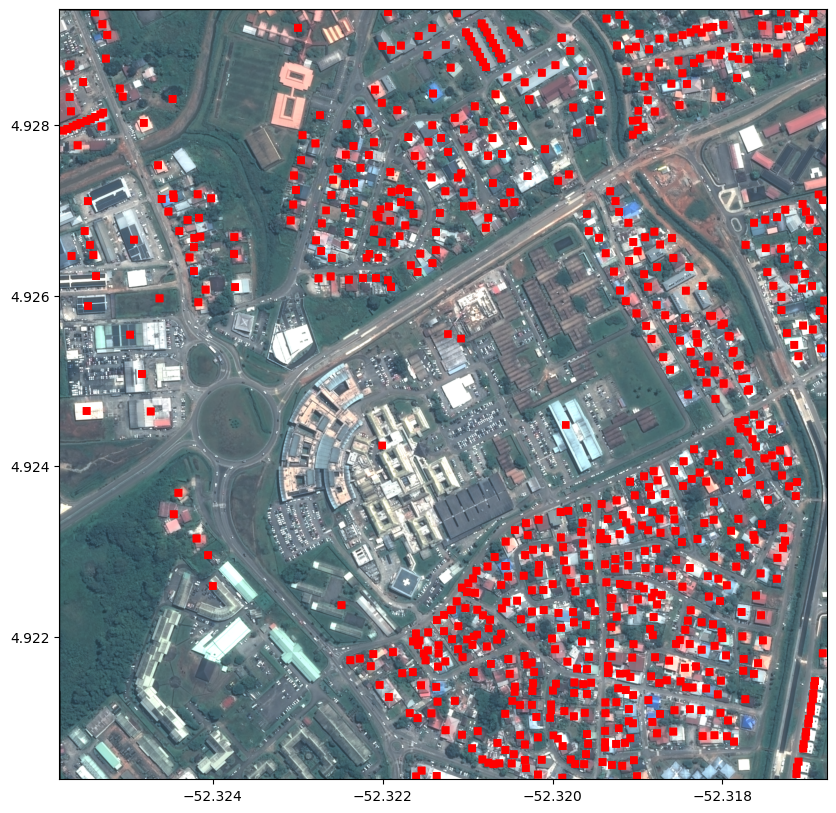

In [122]:
raster_extent = [rasterwgs84.bounds[0], rasterwgs84.bounds[2], rasterwgs84.bounds[1], rasterwgs84.bounds[3]]

red = rasterwgs84.read(1)
fig, ax = plt.subplots(figsize=(10, 10))
show(
    np.moveaxis(climNormStack(rasterwgs84), -1, 0),
    extent = raster_extent,  # sans ce paramètre c'est infaisable.. cf https://stackoverflow.com/questions/61980063/python-how-to-place-a-shapefile-on-top-of-raster-file-in-one-plot-and-then-sa
    ax=ax
)
ril_patch_polygon.plot(color = "red",ax = ax)


Tentative de rasterisation.... c'est pas gagné

Uner piste !! https://gis.stackexchange.com/questions/316626/rasterio-features-rasterize

Pb de l'option, on a des 0 partout, faut-il des polygones ?

### Création d'une mosaique

En fait il est possible de réunir un ensemble d'images raster en une seule et grosse image (pas forcément raisonnable dans notre cas)
Dans un premier temps on liste l'ensemble des fichiers jp2 de la mosaïque que l'on veut créer

In [ ]:
import glob # pour les expressions régulières
%matplotlib inline

# File and folder paths
dirpath = "Cayenne_200722/16bits/ORT_2022072050325085_U22N"

# Make a search criteria to select the DEM files
search_criteria = "*.jp2"
q = os.path.join(dirpath, search_criteria)

file_to_read = glob.glob(q)


Création de la mosaïque

In [ ]:
rasterwgs84.profile

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Create 4 plots next to each other
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, nrows=1, figsize=(12, 4))

# Plot first four files
show(np.moveaxis(climNormStack(src_files_to_mosaic[0]), -1, 0), ax=ax1)
show(np.moveaxis(climNormStack(src_files_to_mosaic[1]), -1, 0), ax=ax2)
show(np.moveaxis(climNormStack(src_files_to_mosaic[2]), -1, 0), ax=ax3)
show(np.moveaxis(climNormStack(src_files_to_mosaic[3]), -1, 0), ax=ax4)# inconsistence entre imshow et show sur l'emplacement des channels
# Do not show y-ticks values in last three axis
for ax in [ax1,ax2, ax3, ax4]:
    ax.yaxis.set_visible(False)

La fameuse fusion

In [ ]:
mosaic, out_trans = merge(src_files_to_mosaic[1:10])

Enorme ! il est temps de bboxer tout ça ?

## TO DO :

- rasterio est confortable mais j'ai le sentilment que gdal peut permettre plus d'opérations
- usage de gdal en ligne de commande à essayer ? https://automating-gis-processes.github.io/2016/Lesson7-gdal-utilities.html
- Passage à l'échelle..utiliser les parcelle scadastrales pour la labellisation ?
- faire un découpage d'image en 4
- trier les images par affine transform et en faire une mosaique ou par nom ?
- on a aps du Ril partout malheureusement..